In [50]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import v2

import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

In [51]:
from tqdm.notebook import tqdm
import scripts.helper_functions
from timeit import default_timer as timer 

In [3]:
torch.__version__, torchvision.__version__

('2.1.0', '0.16.0')

In [4]:
train_data = datasets.FashionMNIST(root="data", train=True, download = True, 
                                   transform=v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
                                   target_transform=None)

test_data = datasets.FashionMNIST(root="data", train=False, download = True, 
                                  transform=v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
                                  target_transform=None)

In [5]:
train_data.data.shape, test_data.data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [26]:
# See the first training data

image, label = train_data[0]
class_names = train_data.classes
train_data.class_to_idx

image.shape, label

(torch.Size([1, 28, 28]), 9)

(-0.5, 27.5, 27.5, -0.5)

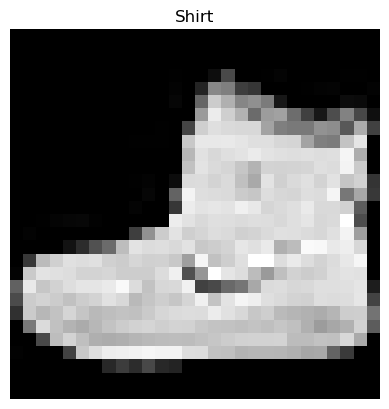

In [29]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis(False)

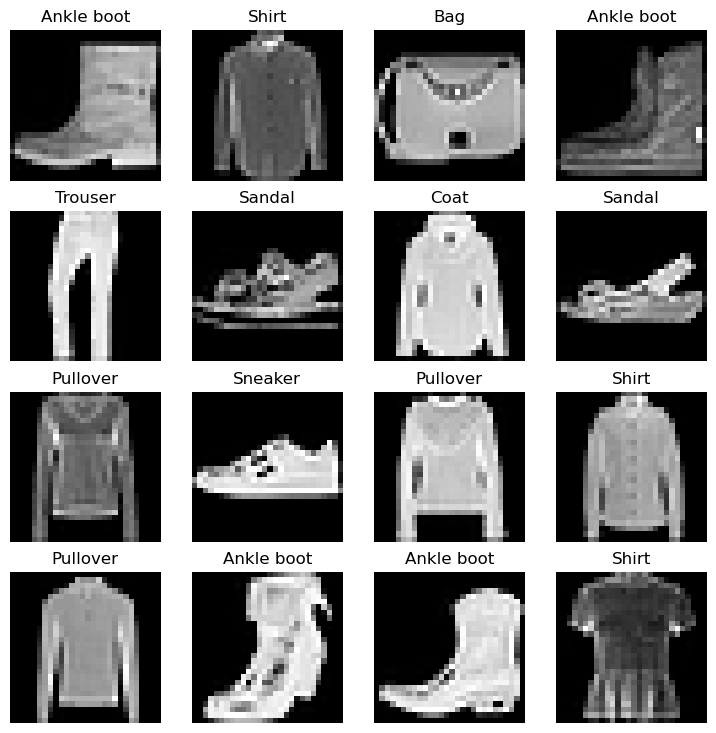

In [27]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

In [95]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_data,batch_size=32,shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

In [96]:
# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7fbb9799cb20>, <torch.utils.data.dataloader.DataLoader object at 0x7fbbb9380ac0>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [25]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(data_loader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

Image size: torch.Size([1, 28, 28])
Label: 6, label size: torch.Size([])


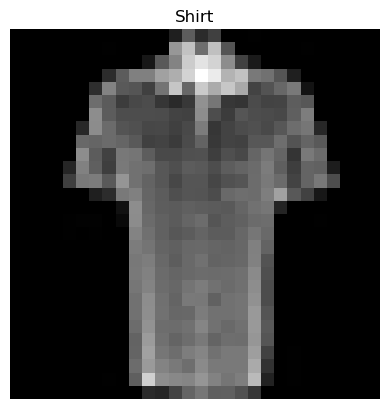

In [30]:
# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis("Off");
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

In [97]:
class FashionMNISTModel_v1(nn.Module):
    """Some Information about FashionMNISTModel"""
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.stack_layer = nn.Sequential(
                nn.Flatten(),
                nn.Linear(in_features = input_shape, out_features = hidden_units),
                nn.ReLU(),
                nn.Linear(in_features = hidden_units, out_features = output_shape)
            )

    def forward(self, x):
        return self.stack_layer(x)

In [98]:
model_v1 = FashionMNISTModel_v1(input_shape=784, hidden_units=10, output_shape=len(class_names))
optim = torch.optim.SGD(model_v1.parameters(), lr = 0.1)
loss_fn = torch.nn.CrossEntropyLoss()

In [42]:
model_v1(torch.rand(1,1,28,28))

tensor([[-0.1979, -0.0970,  0.1551,  0.0115, -0.1776, -0.0065, -0.1263, -0.1023,
         -0.1483,  0.1941]], grad_fn=<AddmmBackward0>)

In [43]:
model_v1(train_features_batch[random_idx])

tensor([[-0.2865, -0.0030,  0.2616,  0.1140, -0.2244, -0.1322, -0.1539, -0.3108,
         -0.2427,  0.1467]], grad_fn=<AddmmBackward0>)

In [63]:
train_time_start_on_cpu = timer()

EPOCHS = 3

torch.manual_seed(42)

for i in tqdm(range(EPOCHS)):

    # Training
    model_v1.train()

    train_loss = 0

    for batch_idx, (X, y) in enumerate(train_dataloader):
        train_logits = model_v1(X)
        loss = loss_fn(train_logits, y)
        train_loss += loss

        optim.zero_grad()
        loss.backward()
        optim.step()

    train_loss  /= len(train_dataloader)
    
    # Testing

    # if i % 10 == 0:

    model_v1.eval()
    with torch.inference_mode():
        loss = 0
        acc = 0

        for (X, y) in test_dataloader:
            test_logits = model_v1(X)
            loss = loss_fn(test_logits, y)
            loss += loss

            acc += scripts.helper_functions.accuracy_fn(y, y_pred=torch.argmax(test_logits, dim=1))

        loss /= len(test_dataloader)
        acc /= len(test_dataloader)

    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {loss:.5f}, Test acc: {acc:.2f}%\n")


train_time_end_on_cpu = timer()
total_train_time_model_0 = scripts.helper_functions.print_train_time(start=train_time_start_on_cpu,end=train_time_end_on_cpu, device="cpu")
       

  0%|          | 0/3 [00:00<?, ?it/s]


Train loss: 0.37897 | Test loss: 0.43982, Test acc: 84.94%


Train loss: 0.37713 | Test loss: 0.43759, Test acc: 84.97%


Train loss: 0.37433 | Test loss: 0.43808, Test acc: 84.79%


Train time on cpu: 54.051 seconds


In [58]:
def train_step( data_loader: DataLoader,
			model: nn.Module,
			loss_fn: torch.nn.Module,
			optim: torch.optim.Optimizer,
			accuracy_fn,
			device: torch.device = None):
	
	train_loss, train_acc = 0, 0

	model.train()
	model.to(device)

	for (X, y) in data_loader:
		X, y = X.to(device), y.to(device)

		train_logits = model(X)
		loss = loss_fn(train_logits, y)
		train_loss += loss
		train_acc += accuracy_fn(y_true = y, y_pred = train_logits.argmax(dim=1))

		optim.zero_grad()
		loss.backward()
		optim.step()

	train_loss  /= len(data_loader)
	train_acc /= len(data_loader)

	print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")



In [59]:
def test_step(data_loader: DataLoader,
         model: nn.Module,
         loss_fn: nn.Module,
         accuracy_fn,
         device: torch.device = None):
    
    test_loss, test_acc = 0, 0

    model.eval()
    model.to(device)

    with torch.inference_mode():
        for (X,y) in data_loader:
            X, y = X.to(device), y.to(device)

            test_logits = model(X)

            test_loss += loss_fn(test_logits, y)
            test_acc += accuracy_fn(y_true = y, y_pred = test_logits.argmax(dim=1))

        
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)

        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")


In [137]:
def eval_model(data_loader: DataLoader,
              model: nn.Module,
              loss_fn: nn.Module,
              accuracy_fn,
              device: torch.device = None):
    """Returns a dictionary containing the results of model predicting on data_loader."""
    
    loss, acc = 0, 0

    model.eval()
    model.to(device)

    with torch.inference_mode():
        for (X,y) in data_loader:
            X, y = X.to(device), y.to(device)

            test_logits = model(X)

            loss += loss_fn(test_logits, y)
            acc += accuracy_fn(y_true = y, y_pred = test_logits.argmax(dim=1))

        
        loss /= len(data_loader)
        acc /= len(data_loader)

        return {"model_name": model.__class__.__name__, # only works when model was created with a class
                "model_loss": loss.item(),
                "model_acc": acc}

In [89]:
torch.manual_seed(42)
device = torch.device('cpu')

start_time = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    
    train_step(data_loader=train_dataloader, 
                model=model_v1, 
                loss_fn=loss_fn,
                optim=optim,
                accuracy_fn=scripts.helper_functions.accuracy_fn,
                device = device)
    
    test_step(data_loader=test_dataloader,
                model=model_v1,
                loss_fn=loss_fn,
                accuracy_fn=scripts.helper_functions.accuracy_fn,
                device = device)

end_time = timer()
total_time = scripts.helper_functions.print_train_time(start=start_time, end=end_time, device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.63327 | Train accuracy: 77.29%
Test loss: 0.50060 | Test accuracy: 82.16%

Epoch: 1
---------
Train loss: 0.47702 | Train accuracy: 83.07%
Test loss: 0.47850 | Test accuracy: 83.05%

Epoch: 2
---------
Train loss: 0.44930 | Train accuracy: 83.91%
Test loss: 0.50560 | Test accuracy: 82.49%


Train time on cpu: 59.595 seconds


In [99]:
torch.manual_seed(42)
device = torch.device('cuda')

start_time = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    
    train_step(data_loader=train_dataloader, 
                model=model_v1, 
                loss_fn=loss_fn,
                optim=optim,
                accuracy_fn=scripts.helper_functions.accuracy_fn,
                device=device)
    
    test_step(data_loader=test_dataloader,
                model=model_v1,
                loss_fn=loss_fn,
                accuracy_fn=scripts.helper_functions.accuracy_fn,
                device = device)

end_time = timer()
total_time = scripts.helper_functions.print_train_time(start=start_time, end=end_time, device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.64627 | Train accuracy: 76.65%
Test loss: 0.51220 | Test accuracy: 81.76%

Epoch: 1
---------
Train loss: 0.48574 | Train accuracy: 82.72%
Test loss: 0.49713 | Test accuracy: 82.59%

Epoch: 2
---------
Train loss: 0.45426 | Train accuracy: 83.71%
Test loss: 0.47373 | Test accuracy: 83.29%


Train time on cuda: 56.714 seconds


In [93]:
# next(iter(test_dataloader))

In [102]:
model_v1_results = eval_model(test_dataloader, model_v1, loss_fn, scripts.helper_functions.accuracy_fn, device = device)
model_v1_results

{'model_name': 'FashionMNISTModel_v1',
 'model_loss': 0.4737292230129242,
 'model_acc': 83.28674121405751}

In [118]:
# Create a convolutional neural network 
class FashionMNISTModel_v2(nn.Module):

    def __init__(self, input_channels: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channels, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units,kernel_size=3,stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)  # this will give us [1,10,7,7] -> Hence -> 7*7
        x = self.classifier(x)
        # print(x.shape)
        return x


In [120]:
torch.manual_seed(42)
model_v2 = FashionMNISTModel_v2(input_channels=1, hidden_units=10, output_shape=len(class_names))
optim = torch.optim.SGD(model_v2.parameters(), lr = 0.1)
loss_fn = nn.CrossEntropyLoss()

In [121]:
## RANDOM TESTING

out = model_v2(torch.rand(1,1,28,28))

torch.manual_seed(42)
images = torch.randn(size=(32, 3, 64, 64)) # [batch_size, color_channels, height, width]
test_image = images[0] # get a single image for testing
print(f"Image batch shape: {images.shape} -> [batch_size, color_channels, height, width]")
print(f"Single image shape: {test_image.shape} -> [color_channels, height, width]") 
# print(f"Single image pixel values:\n{test_image}")

conv_layer_2 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=(5, 5), stride=2, padding=0)

conv_layer_2(test_image.unsqueeze(dim=0)).shape # we need a rank 4 tensor .. hence unsqueeze is important
# print(conv_layer_2.state_dict())

Image batch shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Single image shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]


torch.Size([1, 10, 30, 30])

In [122]:
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

start_time = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    
    train_step(data_loader=train_dataloader, 
                model=model_v2, 
                loss_fn=loss_fn,
                optim=optim,
                accuracy_fn=scripts.helper_functions.accuracy_fn,
                device=device)
    
    test_step(data_loader=test_dataloader,
                model=model_v2,
                loss_fn=loss_fn,
                accuracy_fn=scripts.helper_functions.accuracy_fn,
                device = device)

end_time = timer()
total_time = scripts.helper_functions.print_train_time(start=start_time, end=end_time, device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.59545 | Train accuracy: 78.33%
Test loss: 0.39691 | Test accuracy: 85.78%

Epoch: 1
---------
Train loss: 0.35723 | Train accuracy: 87.20%
Test loss: 0.35161 | Test accuracy: 87.33%

Epoch: 2
---------
Train loss: 0.31660 | Train accuracy: 88.58%
Test loss: 0.31410 | Test accuracy: 88.71%


Train time on cuda: 63.691 seconds


In [123]:
model_v2_results = eval_model(test_dataloader, model_v2, loss_fn, scripts.helper_functions.accuracy_fn, device = device)
model_v2_results

{'model_name': 'FashionMNISTModel_v2',
 'model_loss': 0.3140985667705536,
 'model_acc': 88.70806709265176}

In [124]:
import pandas as pd
compare_results = pd.DataFrame([model_v1_results, model_v2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModel_v1,0.473729,83.286741
1,FashionMNISTModel_v2,0.314099,88.708067


In [125]:
## Prediction on random test samples

import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [127]:
def make_predictions(model: nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits"
            pred_probs.append(pred_prob.cpu())
            
    return torch.stack(pred_probs)

In [132]:
# Make predictions on test samples with model 2

pred_probs= make_predictions(model=model_v2, data=test_samples)
# pred_probs[:2]
pred_classes = pred_probs.argmax(dim=1)
# pred_classes

test_labels, pred_classes

([5, 1, 7, 4, 3, 0, 4, 7, 1], tensor([5, 1, 9, 4, 3, 0, 4, 7, 1]))

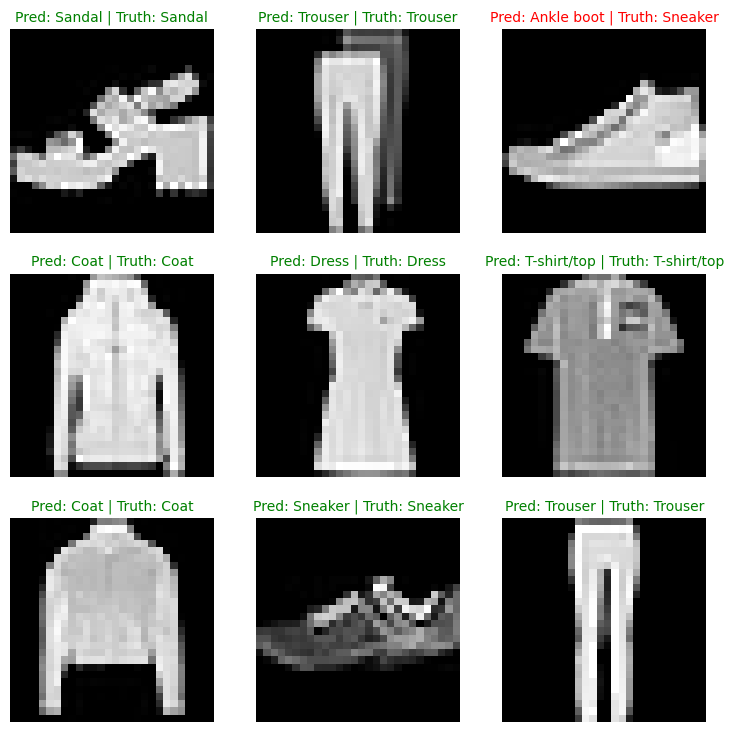

In [133]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(sample.squeeze(), cmap="gray")

  pred_label = class_names[pred_classes[i]]
  truth_label = class_names[test_labels[i]] 

  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False)

In [134]:
## Confusion Matrix
y_preds = []
model_v2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    X, y = X.to(device), y.to(device)
    y_logit = model_v2(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    y_preds.append(y_pred.cpu())
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

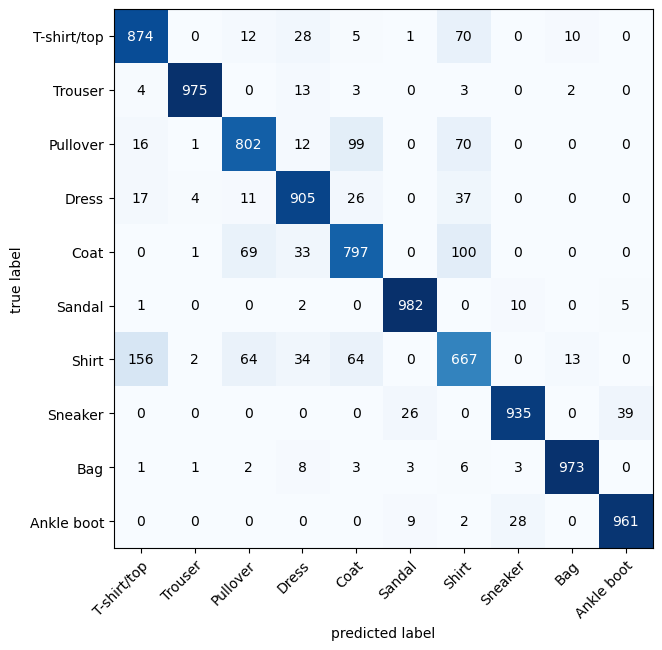

In [135]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor, target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy 
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

In [136]:
## Save the model and Load the model back

from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_v2.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/03_pytorch_computer_vision_model_2.pth


In [145]:

loaded_model_v2 = FashionMNISTModel_v2(input_channels=1, hidden_units=10, output_shape=10) 
loaded_model_v2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

In [147]:
# Evaluate loaded model
torch.manual_seed(42)

loaded_model_2_results = eval_model(
    data_loader=test_dataloader,
    model=loaded_model_v2,
    loss_fn=loss_fn, 
    accuracy_fn=scripts.helper_functions.accuracy_fn,
    device=device
)

loaded_model_2_results

{'model_name': 'FashionMNISTModel_v2',
 'model_loss': 0.3140985667705536,
 'model_acc': 88.70806709265176}

In [148]:
# Check to see if results are close to each other (if they are very far away, there may be an error)
torch.isclose(torch.tensor(model_v2_results["model_loss"]), 
              torch.tensor(loaded_model_2_results["model_loss"]),
              atol=1e-08, # absolute tolerance
              rtol=0.0001) # relative tolerance

tensor(True)